<div style="font-size: 200%; font-weight: bold; color: maroon;">602-Naive Bayes classification algorithm for detecting spam messages. 
    
Scikit-learn + nltk</div>


Classifying spam versus not-spam (called ham) is one of the best know applications of Naive Bayes classification algorithm.

In this notebook you will use nltk (natural language toolkit in python) and naive bayes classification algorithm to do a *very simple Spam/Ham* Classification from SMS dataset from UCI.

Notebook is taken from:

https://www.kaggle.com/astandrik/simple-spam-filter-using-naive-bayes

Dataset is taken from here:
https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

And a good source of tech details (among many excellent other sources):
https://towardsdatascience.com/how-to-build-and-apply-naive-bayes-classification-for-spam-filtering-2b8d3308501


In [2]:
!pip install nltk

  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached regex-2022.10.31-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (770 kB)

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix

[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**PART 1: DATA PREPROCESSING**

since the dataset comes with additional unnamed, column, I need to drop them first

In [5]:
messages = pd.read_csv('spam.csv', encoding='ISO-8859-1')
messages.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
messages = messages.rename(columns={'v1': 'class','v2': 'text'})
#quitarnos 3 variables unamed 2,3,4
#axis 1 quitamos columnas y cambiamos nombre v1 por class y v2 text

In [6]:
messages.head(20)

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [7]:
messages["text"][12]

'URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18'

In [8]:
messages["text"][18]

'Fine if thatåÕs the way u feel. ThatåÕs the way its gota b'

In [9]:
messages.groupby('class').describe()

text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

from above information, we know that:
1. only about 15% of the text messages is classified as a spam
2. there are some duplicate messages, since the number of unique values lower than the count values of the text

in the next part, lext check the length of each text messages to see whether it is correlated with the text classified as a spam or not.

In [10]:
messages['length'] = messages['text'].apply(len) #apply es for, aniade length del mensaje 
#y lo mete en messages [length]

array([<AxesSubplot: title={'center': 'ham'}>,
       <AxesSubplot: title={'center': 'spam'}>], dtype=object)

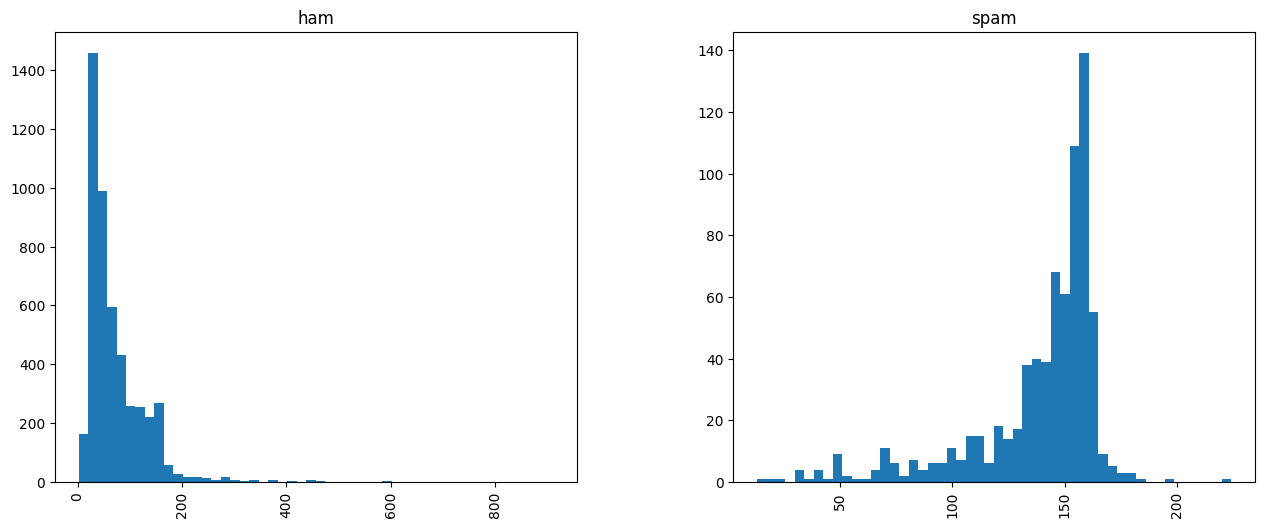

In [11]:
messages.hist(column='length',by='class',bins=50, figsize=(15,6))

from above figure, we can see that most of ham (or not spam) messages only have length under 200 (100 to be exact) while spam messages tend to have higher lentgh above 130 or 140 approximately.

**PART 2: CREATE TOKENIZER**

In [12]:
def process_text(text):
    '''
    What will be covered:
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    
    #1
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #2
    clean_words = [word for word in nopunc.split() 
                   if word.lower() not in stopwords.words('english')]
    
    #3
    return clean_words

let's check what above code will produce

In [13]:
messages['text'].apply(process_text).head(20)

0     [Go, jurong, point, crazy, Available, bugis, n...
1                        [Ok, lar, Joking, wif, u, oni]
2     [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3         [U, dun, say, early, hor, U, c, already, say]
4     [Nah, dont, think, goes, usf, lives, around, t...
5     [FreeMsg, Hey, darling, 3, weeks, word, back, ...
6     [Even, brother, like, speak, treat, like, aids...
7     [per, request, Melle, Melle, Oru, Minnaminungi...
8     [WINNER, valued, network, customer, selected, ...
9     [mobile, 11, months, U, R, entitled, Update, l...
10    [Im, gonna, home, soon, dont, want, talk, stuf...
11    [SIX, chances, win, CASH, 100, 20000, pounds, ...
12    [URGENT, 1, week, FREE, membership, å£100000, ...
13    [Ive, searching, right, words, thank, breather...
14                                       [DATE, SUNDAY]
15    [XXXMobileMovieClub, use, credit, click, WAP, ...
16                                  [Oh, kim, watching]
17    [Eh, u, remember, 2, spell, name, Yes, v, 

**PART 3: SPLITTING DATASET**

In [14]:
msg_train, msg_test, class_train, class_test = train_test_split(messages['text'],
                                                                messages['class'],
                                                                test_size=0.2)

**PART 4: DATA PREPROCESSING**

wait, we've just created the tokenizer isn't it? let the pipeline do the rest.

**PART 5: MODEL CREATION**

here I'll just use pipeline in order to minimize effort on doing preprocessing, transforming then training data on both training dataset and test dataset. Using pipeline will handle them all in a few lines of codes.

In [15]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=process_text)), # converts strings to integer counts de vector a numeros frecuencia relativa de las palabras
    ('tfidf',TfidfTransformer()), # converts integer counts to weighted TF-IDF scores
    ('classifier',MultinomialNB()) # train on TF-IDF vectors with Naive Bayes classifier ###clasificador###
])

**PART 6: TESTING**

In [16]:
pipeline.fit(msg_train,class_train) #x,y

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x7fde14413e20>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [17]:
predictions = pipeline.predict(msg_test)

In [18]:
print(classification_report(class_test,predictions))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       964
        spam       1.00      0.75      0.86       151

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



In [19]:
print(confusion_matrix(class_test, predictions))
#

[[964   0]
 [ 37 114]]


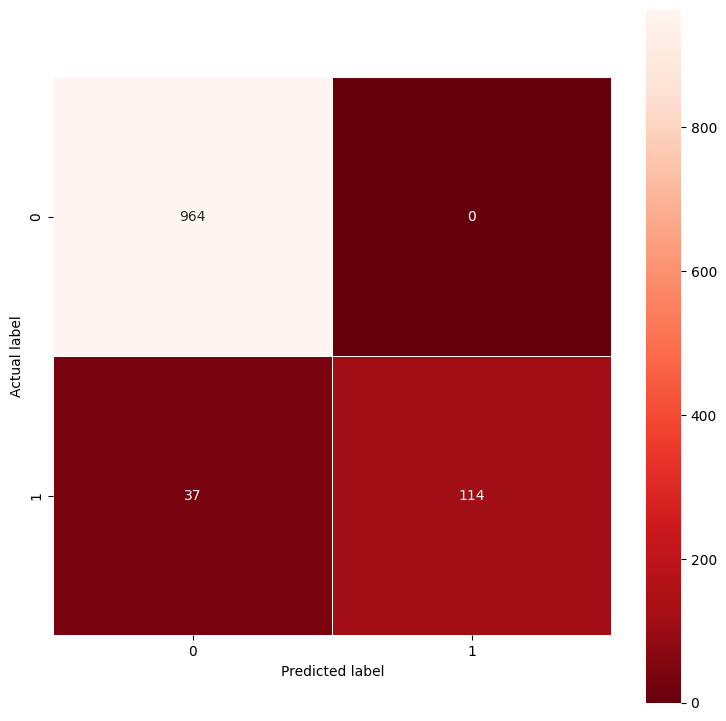

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.figure(figsize=(9,9))

sns.heatmap(confusion_matrix(class_test,predictions),
            annot=True, 
            fmt=".0f", 
            linewidths=.5, 
            square = True, 
            cmap = 'Reds_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


**Notes:**
* we got fairly high but not good enough prediction result here, maybe if the dataset gets higher, maybe naive bayes will do its work better

thanks :)